In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [2]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [5]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [6]:
def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [7]:
def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [8]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [9]:
train_original=train.copy()
test_original=test.copy()

In [10]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [11]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.6873
N    0.3127
Name: Loan_Status, dtype: float64

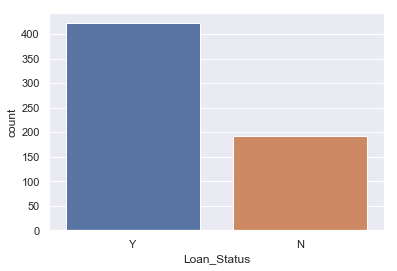

In [12]:
ax = sns.countplot(x="Loan_Status", data=train)

In [13]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [14]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [15]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

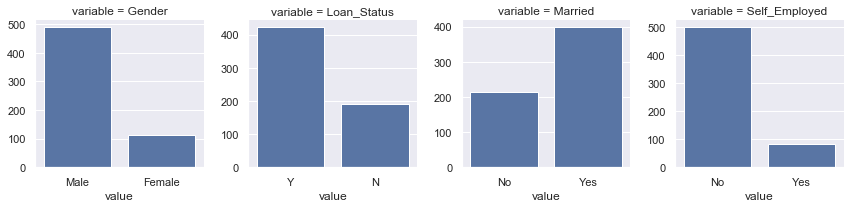

In [16]:
f = pd.melt(train, value_vars=sorted(categorical_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

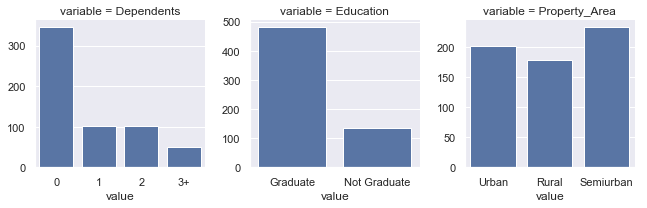

In [17]:
f = pd.melt(train, value_vars=sorted(ordinal_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

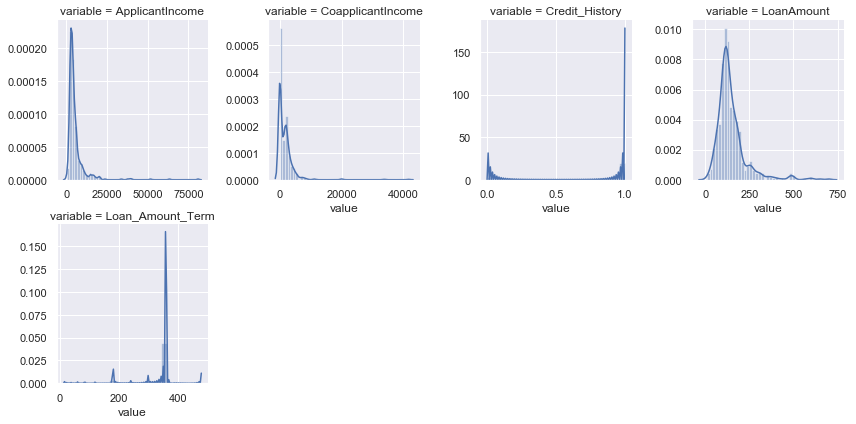

In [18]:
f = pd.melt(train, value_vars=sorted(continuous_ds))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

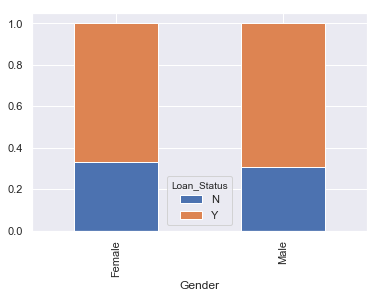

In [19]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.div(gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [20]:
train.groupby(['Gender','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Gender  Credit_History  Loan_Status
Female  0.0             N               16
                        Y                1
        1.0             N               20
                        Y               64
Male    0.0             N               63
                        Y                6
        1.0             N               75
                        Y              307
Name: Loan_ID, dtype: int64

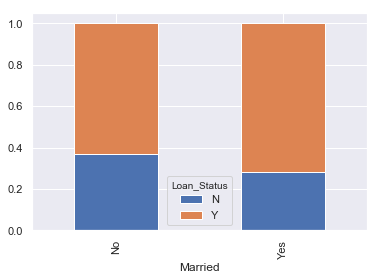

In [21]:
married=pd.crosstab(train['Married'],train['Loan_Status'])
married.div(married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [22]:
train.groupby(['Married','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Married  Credit_History  Loan_Status
No       0.0             N               29
                         Y                3
         1.0             N               45
                         Y              122
Yes      0.0             N               53
                         Y                4
         1.0             N               52
                         Y              253
Name: Loan_ID, dtype: int64

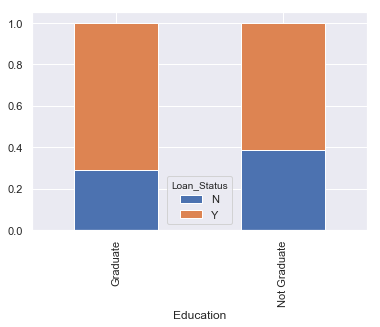

In [23]:
education=pd.crosstab(train['Education'],train['Loan_Status'])
education.div(education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [24]:
train.groupby(['Education','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Credit_History  Loan_Status
Graduate      0.0             N               57
                              Y                6
              1.0             N               73
                              Y              307
Not Graduate  0.0             N               25
                              Y                1
              1.0             N               24
                              Y               71
Name: Loan_ID, dtype: int64

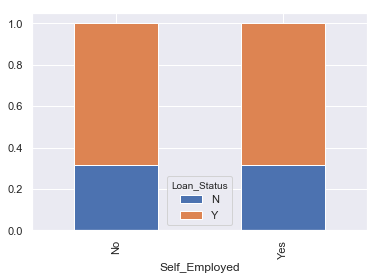

In [25]:
self_employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
self_employed.div(self_employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [26]:
train.groupby(['Education','Self_Employed','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Self_Employed  Credit_History  Loan_Status
Graduate      No             0.0             N               46
                                             Y                6
                             1.0             N               62
                                             Y              249
              Yes            0.0             N               10
                             1.0             N                9
                                             Y               41
Not Graduate  No             0.0             N               23
                                             Y                1
                             1.0             N               19
                                             Y               57
              Yes            0.0             N                2
                             1.0             N                4
                                             Y                9
Name: Loan_ID, dtype: int64

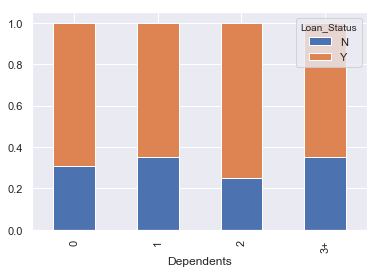

In [27]:
#Credit_History
dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.div(dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [28]:
train.groupby(['Dependents','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Dependents  Credit_History  Loan_Status
0           0.0             N               42
                            Y                3
            1.0             N               60
                            Y              211
1           0.0             N               13
                            Y                1
            1.0             N               17
                            Y               59
2           0.0             N               13
                            Y                1
            1.0             N               12
                            Y               69
3+          0.0             N                9
                            Y                2
            1.0             N                7
                            Y               30
Name: Loan_ID, dtype: int64

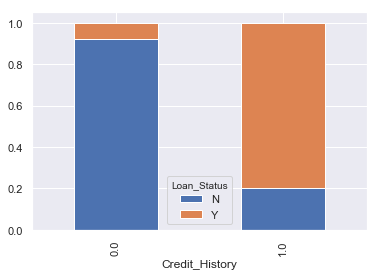

In [29]:
#Credit_History
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

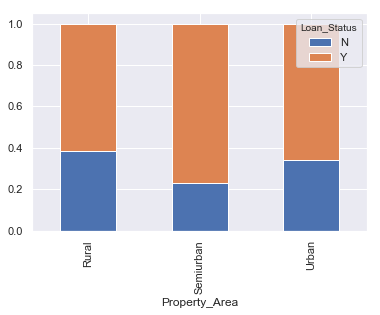

In [30]:
PropertyArea=pd.crosstab(train['Property_Area'],train['Loan_Status'])
PropertyArea.div(PropertyArea.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [31]:
train.groupby(['Property_Area','Loan_Status'])['Loan_ID'].count().reindex()

Property_Area  Loan_Status
Rural          N               69
               Y              110
Semiurban      N               54
               Y              179
Urban          N               69
               Y              133
Name: Loan_ID, dtype: int64

In [32]:
test[ (test['Credit_History'].notnull()) &(test['Dependents']!='0')]['Credit_History'].value_counts()

1.0    127
0.0     26
Name: Credit_History, dtype: int64

In [33]:
Credit_History_Married=pd.crosstab(train['Credit_History'],train['Married'],train['Loan_Status'],margins=True, aggfunc='count')
Credit_History_Married

Married,No,Yes,All
Credit_History,,,
0.0,32,57,89
1.0,167,305,472
All,199,362,561


In [34]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.1433
3,Self_Employed,32,5.2117
4,LoanAmount,22,3.5831
2,Dependents,15,2.4430
5,Loan_Amount_Term,14,2.2801
0,Gender,13,2.1173
1,Married,3,0.4886


In [35]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.9019
2,Self_Employed,23,6.2670
0,Gender,11,2.9973
1,Dependents,10,2.7248
4,Loan_Amount_Term,6,1.6349
3,LoanAmount,5,1.3624


In [36]:
train['Missing_Count'] = train.isnull().sum(axis=1)
test['Missing_Count']  = test.isnull().sum(axis=1)

In [37]:
train[train['Missing_Count'] >=3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Missing_Count
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N,3
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y,3


In [38]:
test[test['Missing_Count'] >=3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Missing_Count


In [39]:
badcredit_loan_approved = train[(train['Credit_History']==0 ) &( train['Loan_Status'] =='Y')]['Loan_ID'].tolist()

In [40]:
train.drop(train[train['Missing_Count'] >=3].index,inplace=True)

In [41]:
train[train['Missing_Count'] >=3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Missing_Count


In [43]:
#train_credit_null_index = train[(train['Married']=='Yes') &
#                                (train['CoapplicantIncome']!=0) 
#                                &(train['Credit_History'].isnull())].index.tolist()
#test_credit_null_index=test[(test['Married']=='Yes') & 
#                            (test['CoapplicantIncome']!=0) &
#                            (test['Credit_History'].isnull())].index.tolist()

#train.loc[train_credit_null_index,'Credit_History']=1
#test.loc[test_credit_null_index,'Credit_History']=1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True)
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train_Married_null_index = train[ 
                                (train['CoapplicantIncome']!=0) 
                                &(train['Married'].isnull())].index.tolist()

train.loc[train_Married_null_index,'Married']='Yes'
train['Married'].fillna('No',inplace=True)

In [44]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
0,LoanAmount,20,3.268


In [45]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
0,LoanAmount,5,1.3624


In [46]:
def emi_calculator(row): 
    r = 8.7 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 
 

In [47]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [48]:
property_map = {'Rural':1,'Urban':2,'Semiurban':3}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']

full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)


In [49]:
#full_dataset["Married_NoDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["Married_WithDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] !=0)) * 1
#full_dataset["NotMarried_NoDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["NotMarried_WithDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] !=0)) * 1
#full_dataset['Loan_Amount_Term']= full_dataset['Loan_Amount_Term']/12
#full_dataset["Graduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["Graduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["NotGraduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["NotGraduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["Married_CoApplicant_NoDependents"] = ((full_dataset["Married"] == 1) & 
#                                                    (full_dataset['Dependents'] =='0')&
#                                                    (full_dataset['HasCoApplicant']=='Y')
#
#) * 1
full_dataset.head()


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Missing_Count,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,1,2,No,5849.0,N,1018.0717,4831.9283,4831.9283,44.9923,44.9923
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,0,1,No,6091.0,Y,1002.4090,5089.5910,3581.5910,35.8047,47.5859
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,0,2,Yes,3000.0,N,516.8672,2484.1328,2484.1328,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,0,2,No,4941.0,Y,939.7585,4002.2415,1644.2415,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,0,2,No,6000.0,N,1104.2162,4896.7838,4896.7838,42.5532,42.5532


In [50]:
full_dataset[(full_dataset['Loan_Status']==1)&(full_dataset['Credit_History']==0)]

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Missing_Count,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
121,2137,8980.0,0.0,0,Graduate,0,137.0,360.0,LP001431,1.0,0,0,3,No,11117.0,Y,1072.8909,10045.1091,1065.1091,15.5985,81.1460
154,39999,0.0,0.0,3,Graduate,1,600.0,180.0,LP001536,1.0,1,0,3,No,39999.0,N,5978.9885,34021.0115,34021.0115,66.6650,66.6650
200,4923,0.0,0.0,2,Graduate,1,166.0,360.0,LP001677,1.0,0,0,3,No,4923.0,N,1299.9992,3624.0008,3624.0008,29.6566,29.6566
266,4333,1811.0,0.0,3,Graduate,1,160.0,360.0,LP001882,1.0,1,0,2,No,6144.0,Y,1253.0113,4891.9887,3080.9887,27.0813,38.4000
325,4917,0.0,0.0,0,Graduate,1,130.0,360.0,LP002068,1.0,0,0,1,No,4917.0,N,1018.0717,3899.9283,3899.9283,37.8231,37.8231
451,2483,2466.0,0.0,0,Graduate,1,90.0,180.0,LP002449,1.0,1,0,1,No,4949.0,Y,896.8483,4053.1517,1587.1517,27.5889,54.9889
525,5285,1430.0,0.0,1,Not Graduate,1,161.0,360.0,LP002706,1.0,1,0,3,No,6715.0,Y,1260.8426,5455.1574,4025.1574,32.8261,41.7081


In [51]:
full_dataset[(full_dataset['Loan_Status']==0)&(full_dataset['Credit_History']==0)].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Missing_Count,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
7,3036,2504.0,0.0,3,Graduate,1,158.0,360.0,LP001014,0.0,1,0,3,No,5540.0,Y,1237.3486,4303.6514,1799.6514,19.2152,35.0633
17,3510,0.0,0.0,0,Graduate,0,76.0,360.0,LP001036,0.0,0,0,2,No,3510.0,N,595.1804,2915.8196,2915.8196,46.1842,46.1842
20,7660,0.0,0.0,0,Not Graduate,1,104.0,360.0,LP001043,0.0,1,0,2,No,7660.0,N,814.4573,6846.5427,6846.5427,73.6538,73.6538
22,2600,1911.0,0.0,0,Not Graduate,1,116.0,360.0,LP001047,0.0,1,0,3,No,4511.0,Y,908.4332,3603.5668,1692.5668,22.4138,38.8879
23,3365,1917.0,0.0,2,Not Graduate,1,112.0,360.0,LP001050,0.0,1,1,1,No,5282.0,Y,877.1079,4405.8921,2488.8921,30.0446,47.1607


In [52]:
full_dataset[(full_dataset['Loan_Status']==0)&(full_dataset['Credit_History']==1)].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Missing_Count,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,0,1,No,6091.0,Y,1002.4090,5089.5910,3581.5910,35.8047,47.5859
9,12841,10968.0,1.0,1,Graduate,1,349.0,360.0,LP001020,0.0,1,0,3,No,23809.0,Y,2733.1308,21076.8692,10108.8692,36.7937,68.2206
13,1853,2840.0,1.0,0,Graduate,1,114.0,360.0,LP001029,0.0,0,0,1,No,4693.0,Y,892.7705,3801.2295,961.2295,16.2544,41.1667
18,4887,0.0,1.0,0,Not Graduate,1,133.0,360.0,LP001038,0.0,1,0,1,No,4887.0,N,1041.5656,3846.4344,3846.4344,36.7444,36.7444
24,3717,2925.0,1.0,1,Graduate,1,151.0,360.0,LP001052,0.0,1,2,3,No,6642.0,Y,1182.5294,5460.4706,2535.4706,24.6159,43.9868


In [53]:
full_dataset[(full_dataset['Loan_Status']==1)&(full_dataset['Credit_History']==1)].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Missing_Count,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,1,2,No,5849.0,N,1018.0717,4831.9283,4831.9283,44.9923,44.9923
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,0,2,Yes,3000.0,N,516.8672,2484.1328,2484.1328,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,0,2,No,4941.0,Y,939.7585,4002.2415,1644.2415,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,0,2,No,6000.0,N,1104.2162,4896.7838,4896.7838,42.5532,42.5532
5,5417,4196.0,1.0,2,Graduate,1,267.0,360.0,LP001011,1.0,1,0,2,Yes,9613.0,Y,2090.9626,7523.0374,3327.0374,20.2884,36.0037


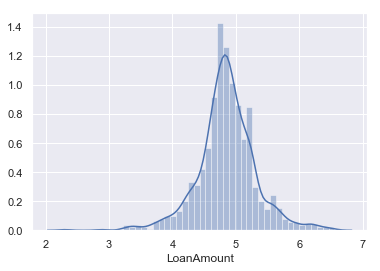

In [54]:
sns.distplot(np.log1p(full_dataset['LoanAmount']))

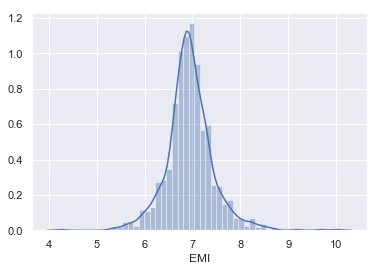

In [55]:
sns.distplot(np.log1p(full_dataset['EMI']))

In [56]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

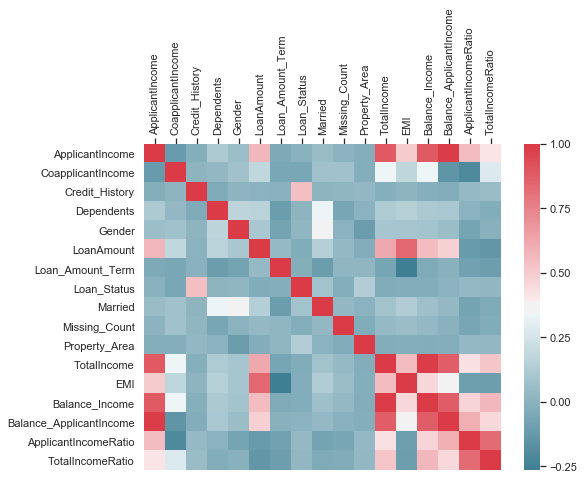

In [57]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#correlation = correlation.sort_values('Loan_Status', ascending=False)
#plt.figure(figsize=(8,10))
#sns.barplot( correlation['Loan_Status'][1:], correlation.index[1:], orient='h')
#plt.show()

In [58]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 
                   'Balance_Income','ApplicantIncome','Missing_Count',
                   ],axis=1,inplace=True)

In [59]:
full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

In [60]:
full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

In [61]:
from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
scaler = LogTransformer(['EMI','LoanAmount'])
full_dataset =scaler.fit_transform(full_dataset)

In [62]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)



In [63]:
null_dataset =get_nullframe(full_dataset)
null_dataset

,feature,count,null_percent
0,Loan_Status,367,37.4872


In [64]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [65]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=10)

(612, 14)
(367, 14)


In [66]:
X_trainmodel.head()

,Credit_History,Dependents,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,EMI,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Education_Graduate,Self_Employed_Yes,HasCoApplicant_Y
88,1.0,0,1,5.3519,360.0,0,2,7.4058,6922.4227,40.7905,40.7905,1,0,0
512,1.0,0,1,5.7430,360.0,0,1,7.7983,3380.4593,18.6977,30.4855,1,0,1
117,1.0,0,1,5.1705,360.0,1,1,7.2236,4198.5189,31.8171,44.0571,1,0,1
393,1.0,2,1,4.7362,360.0,1,2,6.7866,2216.0608,27.4336,39.8230,1,0,1
417,1.0,0,1,4.7274,360.0,1,1,6.7778,148.8921,9.1518,33.9107,1,0,1


Accuracy: 81.699
Accuracy: 80.828


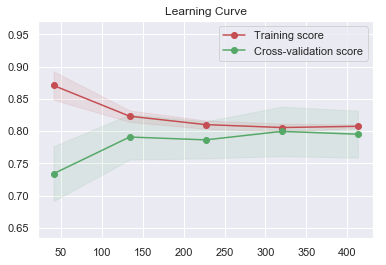

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Penalty: l1
Best C: 1.0
Accuracy: 81.046


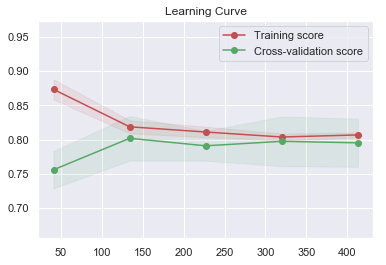

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02, 4.64159e+02,
       2.15443e+03, 1.00000e+04, 4.64159e+04, 2.15443e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Classification report
              precision    recall  f1-score   support

         0.0       0.89      0.39      0.54        41
         1.0       0.81      0.98      0.89       112

   micro avg       0.82      0.82      0.82       153
   macro avg       0.85      0.69      0.72       153
weighted avg      

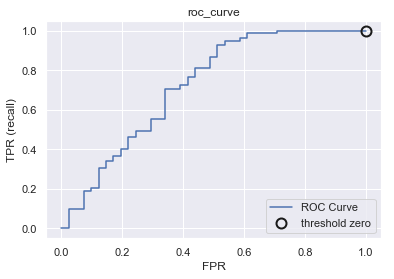

In [67]:
from sklearn.linear_model import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel, y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))
logrmodel ,result = test_classifier(logrmodel,X_trainmodel,y_trainmodel,kfold)
print(logrmodel)

# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 6, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
clf = GridSearchCV(logrmodel, hyperparameters, cv=5, verbose=0,scoring='accuracy')
best_model = clf.fit(X_trainmodel, y_trainmodel.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

best_lr_model ,result = test_classifier(best_model,X_trainmodel,y_trainmodel,kfold)
print(best_lr_model)

y_pred=measure_performance(X_val,y_val,best_lr_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_lr_model)

In [68]:
from xgboost.sklearn import XGBClassifier

In [69]:
xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [70]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Accuracy: 87.582


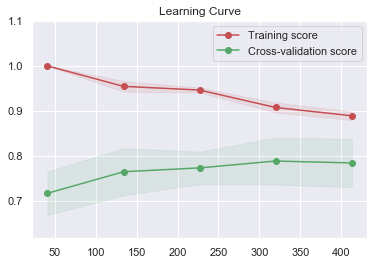

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


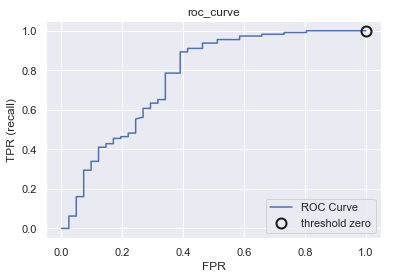

In [71]:
best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)

plot_roc(X_val,y_val,best_model)



In [72]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

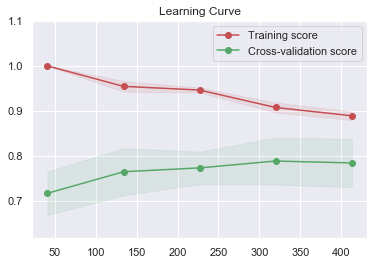

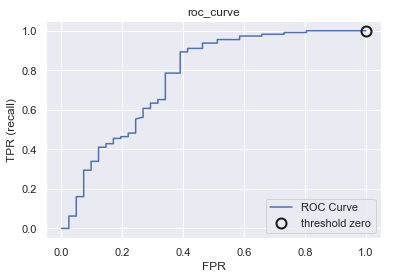

Classification report
              precision    recall  f1-score   support

         0.0       0.77      0.49      0.60        41
         1.0       0.83      0.95      0.89       112

   micro avg       0.82      0.82      0.82       153
   macro avg       0.80      0.72      0.74       153
weighted avg       0.82      0.82      0.81       153

Confusion matrix
[[ 20  21]
 [  6 106]]


In [73]:
evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [74]:
 def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [75]:
import xgboost as xgb

In [122]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 0.7,
          'colsample_bylevel': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          }

num_boost_round =60

In [123]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist, feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.178649	eval-merror:0.156863	train-accuracy_score:0.821351	eval-accuracy_score:0.843137
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.178649	eval-merror:0.150327	train-accuracy_score:0.821351	eval-accuracy_score:0.849673
[2]	train-merror:0.183007	eval-merror:0.150327	train-accuracy_score:0.816993	eval-accuracy_score:0.849673
[3]	train-merror:0.178649	eval-merror:0.150327	train-accuracy_score:0.821351	eval-accuracy_score:0.849673
[4]	train-merror:0.178649	eval-merror:0.156863	train-accuracy_score:0.821351	eval-accuracy_score:0.843137
[5]	train-merror:0.178649	eval-merror:0.150327	train-accuracy_score:0.821351	eval-accuracy_score:0.849673
[6]	train-merror:0.176471	eval-merror:0.150327	train-accuracy_score:0.823529	eval-accuracy_score:0.849673
[7]	train-merror:0.176471	eval-merror:0.150327	train-accuracy_score:0.823

In [124]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

In [125]:
import operator
create_feature_map(X_trainmodel)

Text(0.5,0,'relative importance')

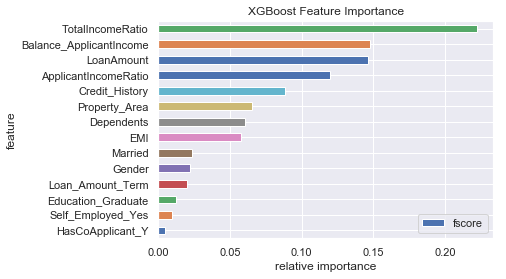

In [126]:
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [127]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

In [128]:
 
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_XgBooost"+timestamp+"_out.csv"

In [129]:
submission.to_csv(filename)

### Public Leaderboard - Practice Problem: Loan Prediction III
### Rank 156/35442		KrishnaMohan	0.8055555556

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
original_params = {'n_estimators':40, 'max_leaf_nodes':10, 'max_depth': 3, 'random_state': 2,
                   'min_samples_split':6,'min_samples_leaf':5,'learning_rate':0.1 }

gbc =GradientBoostingClassifier(**original_params)
gbc.fit(X_trainmodel, y_trainmodel.values.ravel())
 
best_gc =  gbc
best_gc ,result = test_classifier(best_gc,X_trainmodel,y_trainmodel,kfold)
print(best_gc)

y_pred=measure_performance(X_val,y_val,best_gc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_gc)

In [ ]:
test_y =best_gc.predict(test_X)

In [ ]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_GradientBoosting"+timestamp+"_out.csv"

submission.to_csv(filename)